In [1]:
import pandas
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, mean_squared_error, r2_score, explained_variance_score, make_scorer
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from xgboost import plot_importance

#import shap
import scipy.stats as st
from scipy.stats import randint, poisson
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
plt.rcParams['font.size'] = 18
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import random
from itertools import combinations
from matplotlib.font_manager import FontProperties
from tqdm import tqdm

#plt.style.use('ggplot'); plt.style.use('seaborn-ticks')

In [2]:
df1 = pd.read_csv('data2\etalon_jitter_16Mar20_etalon.ccfSum-telemetryCLEANED.csv')
df2 = pd.read_csv('data2\etalon_jitter_18Mar20_etalon.ccfSum-telemetryCLEANED.csv')
df3 = pd.read_csv('data2\etalon_jitter_26Mar20_Cryo_etalon.ccfSum-telemetryCLEANED.csv')
df4 = pd.read_csv('data2\etalon_jitter_26Mar_whitebox_etalon.ccfSum-telemetryCLEANED.csv')

In [3]:
frames = [df1, df2, df3, df4]
data = np.array(pd.concat(frames))

In [4]:
np.array(df1)[-1,0] - np.array(df1)[0,0]

0.1453199996612966

In [5]:
# jd = np.array((result['JD_UTC']))

#print(df1['JD_UTC'][0])
# print(df2['JD_UTC'][10])
# print(df3['JD_UTC'][10])
# print(df4['JD_UTC'][10])

# print(jd[10], jd[len(df1)+10], jd[len(df1)+len(df2)+10], jd[len(df1)+len(df2)+len(df3)+10])

In [6]:
names_temp = np.array(df1.axes)
names = []
for i in range(len(names_temp[1])):
    names.append(names_temp[1][i])
names = np.array(names)

# Regression - XGBoost

In [7]:
#test = np.array(df4)[:,3:]
X_test = np.array(df4)[:,3:]
y_test = np.array(df4)[:,1]


frames = [df1, df2, df3]
X = np.array(pd.concat(frames))[:,3:]
y = np.array(pd.concat(frames))[:,1]

### Random Search

In [8]:
seed = 42

parameters_RandomSearch = {'eta': st.uniform(), 
                           'num_round': st.randint(1,11),
                           'max_depth': st.randint(1,10)}

clf_xgb = xgb.XGBRegressor(random_state = seed)

n_iter_search = 10

exp_var = make_scorer(explained_variance_score)
r2 = make_scorer(r2_score)



RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5, 
                                  return_train_score=True,
                                  random_state=seed,
                                  verbose = False,
                                  scoring = exp_var)

In [9]:
RandomSearch.fit(X, y);

RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.5f}")

[18:43:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:43:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:43:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[18:43:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:43:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:43:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bi

In [10]:
model = xgb.XGBRegressor()
model.fit(X, y);
ypred = model.predict(X_test)

In [11]:
explained_variance_score(y_test,ypred)

-0.20819765119276123

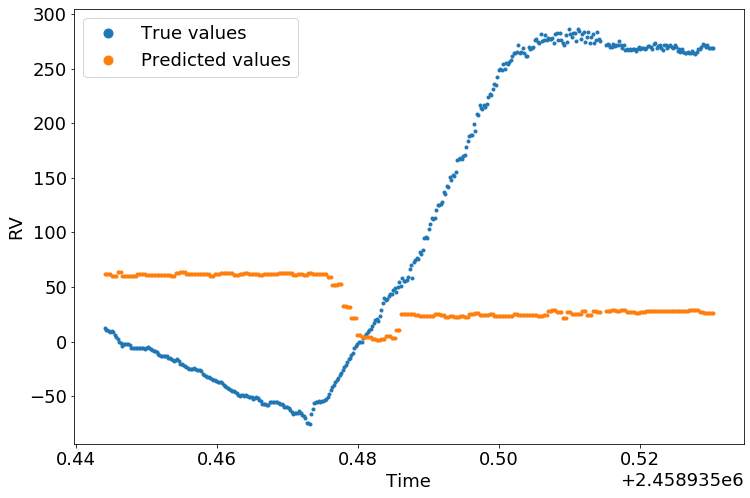

In [12]:
time =  np.array(df4)[:,0]

plt.figure(figsize=(12,8))
plt.plot(time,y_test, '.', color='C0', linewidth = 2, label = 'True values')
plt.plot(time,ypred, '.', color='C1', linewidth = 2, label = 'Predicted values')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend(markerscale=3);

### Shap

In [13]:
# shap_values = shap.TreeExplainer(model).shap_values(X)
# shap.summary_plot(shap_values, X, plot_type="bar")

# NN

In [14]:
scaler = StandardScaler()
scaler.fit(X)
StandardScaler(copy=True, with_mean=True, with_std=True)
X_train = scaler.transform(X)
X_test = scaler.transform(X_test)

In [15]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100),max_iter=10000, learning_rate='adaptive', random_state=seed);
mlp.fit(X_train,y);
ypred_nn = mlp.predict(X_test)


# r2_score(y_test,ypred_nn)

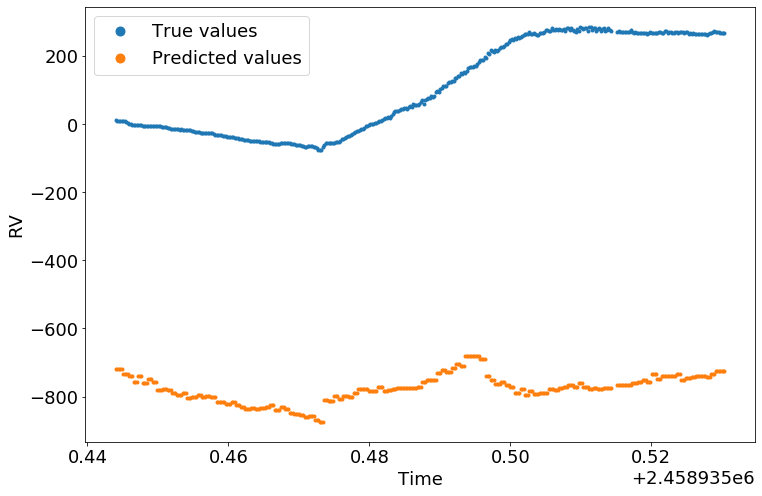

In [16]:
plt.figure(figsize=(12,8))
plt.plot(time,y_test, '.', color='C0', linewidth = 2, label = 'True values')
plt.plot(time,ypred_nn, '.', color='C1', linewidth = 2, label = 'Predicted values')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend(markerscale=3);

# Simones script

In [17]:
#%run -i "LSTM.py"

# New data

In [18]:
dfnew = pd.read_csv('data\etalon_jitter_29May20_etalon.ccfSum-telemetry.csv')
newData = np.array(dfnew)

np.savetxt('AllDataNew.txt', newData)



0.1283249999396503

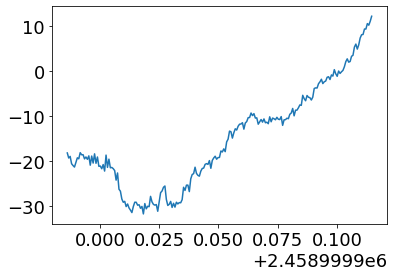

In [19]:
plt.plot(newData[:,0],newData[:,1])

newData[-1,0]-newData[0,0]

In [20]:
data1 = np.array(df1)
data2 = np.array(df2)
data3 = np.array(df3)
data4 = np.array(df4)

Text(0.5, 1.0, 'Data4')

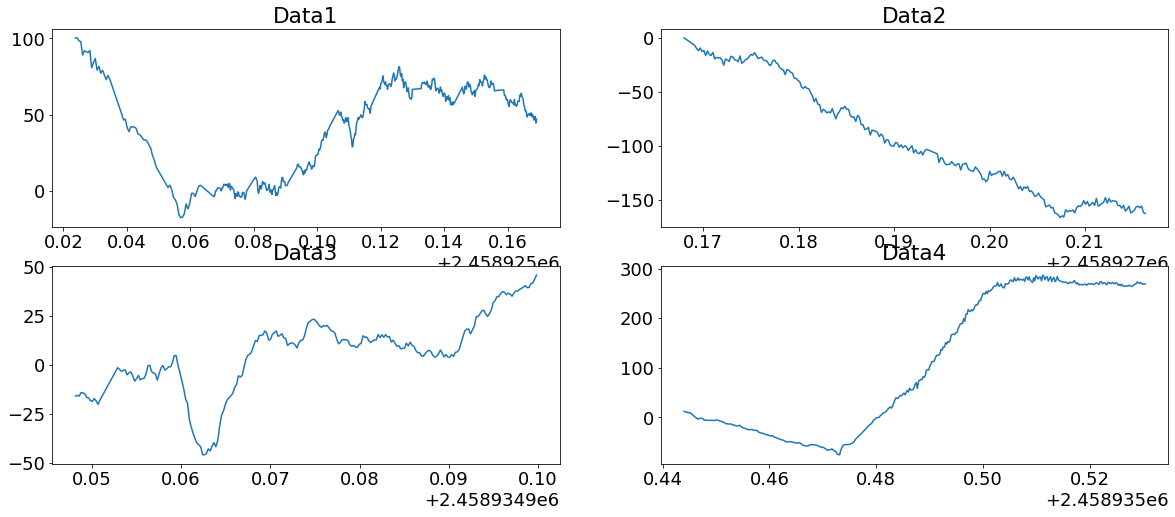

In [21]:
plt.figure(figsize=(20,8))

plt.subplot(221)
plt.plot(data1[:,0],data1[:,1])
plt.title('Data1')

plt.subplot(222)
plt.plot(data2[:,0],data2[:,1])
plt.title('Data2')

plt.subplot(223)
plt.plot(data3[:,0],data3[:,1])
plt.title('Data3')

plt.subplot(224)
plt.plot(data4[:,0],data4[:,1])
plt.title('Data4')


In [22]:
X_test = newData[:,3:]
y_test = newData[:,1]


frames_0 = [df1, df2, df3, df4]
frames_1 = [df1, df2, df3]
frames_2 = [df1, df2]
frames_3 = [df1]

frame_tot = [df1, df2, df3, df4]

X = np.array(pd.concat(frames_1))[:,3:]
y = np.array(pd.concat(frames_1))[:,1]

input = frame_tot

output = sum([list(map(list, combinations(input, i))) for i in range(len(input) + 1)], [])
output = output[1:]

In [23]:
# #X_test = newData[:,3:]
# X_test = np.array([newData[:,8], newData[:,14]]).T
# y_test = newData[:,1]

# time =  newData[:,0]

# plt.figure(figsize=(16,10))

# for i in tqdm(range(len(output))):
#     frames = output[i]
#     #X = np.array(pd.concat(frames))[:,3:]
#     X_rear, X_centre = np.array(pd.concat(frames))[:,8], np.array(pd.concat(frames))[:,14]
#     X = np.array([X_rear, X_centre]).T
#     y = np.array(pd.concat(frames))[:,1]
    
#     seed = 42

#     parameters_RandomSearch = {'eta': st.uniform(), 
#                                'num_round': st.randint(1,11),
#                                'max_depth': st.randint(1,10)}

#     clf_xgb = xgb.XGBRegressor(random_state = seed)

#     n_iter_search = 10

#     exp_var = make_scorer(explained_variance_score)
#     r2 = make_scorer(r2_score)



#     RandomSearch = RandomizedSearchCV(clf_xgb, 
#                                       param_distributions=parameters_RandomSearch, 
#                                       n_iter=n_iter_search, 
#                                       cv=5, 
#                                       return_train_score=True,
#                                       random_state=seed,
#                                       verbose = False,
#                                       scoring = exp_var)
    
#     RandomSearch.fit(X, y);
#     print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.5f}")
#     ypred = RandomSearch.predict(X_test)
    
#     if i == 0:
#         plt.plot(y_test, '.-', color='C0', linewidth = 8, label = 'True values')
#     plt.plot(ypred, '.', color=f'C{i+1}', linewidth = 2, label = f'Predicted values: output{i}')
#     plt.xlabel('Time')
#     plt.ylabel('RV')
#     plt.ylim(-50,50)
#     plt.legend(markerscale=3, loc='center left', bbox_to_anchor=(1, 0.5));
    
# plt.show

In [24]:
seed = 42

parameters_RandomSearch = {'eta': st.uniform(), 
                           'num_round': st.randint(1,11),
                           'max_depth': st.randint(1,10)}

clf_xgb = xgb.XGBRegressor(random_state = seed)

n_iter_search = 10

exp_var = make_scorer(explained_variance_score)
r2 = make_scorer(r2_score)



RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5, 
                                  return_train_score=True,
                                  random_state=seed,
                                  verbose = False,
                                  scoring = exp_var)

In [25]:
# RandomSearch.fit(X, y);

# RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
# print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.5f}")

In [26]:
model = xgb.XGBRegressor()
model.fit(X, y);
ypred = model.predict(X_test)

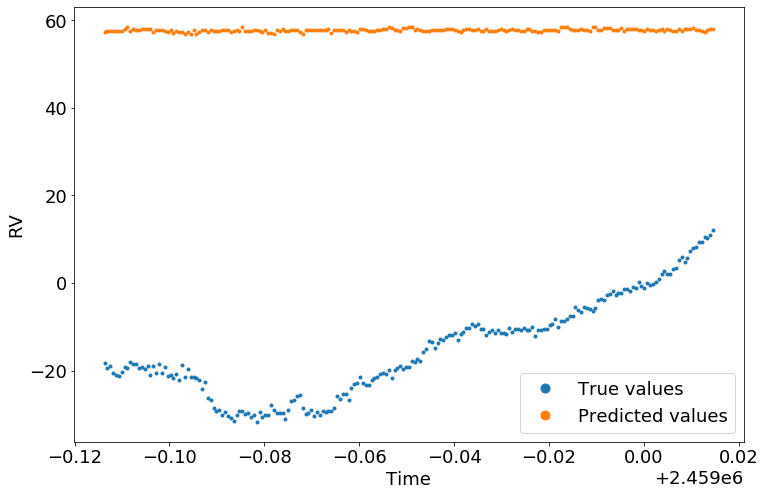

In [27]:
time =  newData[:,0]

plt.figure(figsize=(12,8))
plt.plot(time,y_test, '.', color='C0', linewidth = 2, label = 'True values')
plt.plot(time,ypred, '.', color='C1', linewidth = 2, label = 'Predicted values')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend(markerscale=3);

In [28]:
v3 = np.loadtxt('../../../Downloads/AllDatav3.txt')

# NN

In [29]:
# seed = 42

# time =  newData[:,0]

# X_test = newData[:,3:]
# y_test = newData[:,1]

# plt.figure(figsize=(12,8))

# for i in range(len(output)):
    
#     frames = output[i]
    
#     X = np.array(pd.concat(frames))[:,3:]
#     y = np.array(pd.concat(frames))[:,1]
    
#     scaler = StandardScaler()
#     scaler.fit(X)
#     StandardScaler(copy=True, with_mean=True, with_std=True)
#     X_train = scaler.transform(X)
#     X_test = scaler.transform(X_test)
    
#     mlp = MLPRegressor(hidden_layer_sizes=(28,27),max_iter=10000, learning_rate='adaptive', random_state=seed);
#     mlp.fit(X_train,y);
#     ypred = mlp.predict(X_test)

    
    
#     if i == 0:
#         plt.plot(time,y_test, '.', color='C0', linewidth = 2, label = 'True values')
#     plt.plot(time,ypred, '.', color=f'C{i+1}', linewidth = 2, label = f'Predicted values: frames_{i}')
#     plt.xlabel('Time')
#     plt.ylabel('RV')
#     plt.legend(markerscale=3);
    
# plt.show

# Med Jonathans NN random search

In [30]:
# seed = 42

# time =  newData[:,0]

# X_test = newData[:,3:]
# y_test = newData[:,1]


# # Create a model with no hyperparameters


# class hidden_layer:
#     def __init__(self, min_range, max_range, max_layers=2):
#         self.max_layers = max_layers
#         self.min_range = min_range
#         self.max_range = max_range
    
#     def rvs(self,random_state):
#         self.layers = np.random.randint(1,self.max_layers+1)
#         sizes = []
#         for i in range(self.layers):
#             if i==0:
#                 sizes.append( np.random.randint(self.min_range, self.max_range) )
#             elif sizes[i-1]==1:
#                 sizes.append( 1 )
#             else:
#                 sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
#         return tuple(sizes)

# # Parameters to search
# parameters_RandomSearch = {
#     "activation": ["relu"],#, "logistic", "tanh"],
#     "hidden_layer_sizes": hidden_layer(1, 100, max_layers=5),
#     "learning_rate_init": st.uniform()
# }

# # Number of search rounds
# n_iter_search = 100

# plt.figure(figsize=(12,8))

# for i in tqdm(range(len(output))):

#     # Initialize
#     clf_NN = MLPRegressor(learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)
#     RandomSearch = RandomizedSearchCV(clf_NN, 
#                                       param_distributions=parameters_RandomSearch, 
#                                       n_iter=n_iter_search, 
#                                       cv=5,  
#                                       return_train_score=True,
#                                       random_state=0,
#                                       verbose = False, 
#                                       n_jobs = -1,
#                                       scoring = 'neg_root_mean_squared_error')


#     frames = output[i]
    
#     X = np.array(pd.concat(frames))[:,3:]
#     y = np.array(pd.concat(frames))[:,1]
    
#     # fit the random search instance
#     RandomSearch.fit(X, y);

#     print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

#     y_pred = RandomSearch.predict(X_test)


#     if i == 0:
#         plt.plot(y_test, '.', color='C0', linewidth = 2, label = 'True values')
#     plt.plot(ypred, '.', color=f'C{i+1}', linewidth = 2, label = f'Predicted values: frames_{i}')
#     plt.xlabel('Time')
#     plt.ylabel('RV')
#     plt.legend(markerscale=3, loc='center left', bbox_to_anchor=(1, 0.5));

# plt.show

In [31]:
#names[8], names[14]

# Skaleret data

In [32]:
df1_s = np.loadtxt('data2\Data1scaled.txt')
df2_s = np.loadtxt('data2\Data2scaled.txt')
df3_s = np.loadtxt('data2\Data3scaled.txt')
df4_s = np.loadtxt('data2\Data4scaled.txt')
df5_s = np.loadtxt('data2\Data5scaled.txt')

In [33]:
frame_tot = [df1_s, df2_s, df3_s, df4_s]

input = frame_tot

output = sum([list(map(list, combinations(input, i))) for i in range(len(input) + 1)], [])
output = output[1:]

input_list = ['df1', 'df2', 'df3', 'df4']

output_list = sum([list(map(list, combinations(input_list, i))) for i in range(len(input_list) + 1)], [])
output_list = output_list[1:]

for i in range(len(output_list)):
    print(f' Frames_{i} = {output_list[i]}')

 Frames_0 = ['df1']
 Frames_1 = ['df2']
 Frames_2 = ['df3']
 Frames_3 = ['df4']
 Frames_4 = ['df1', 'df2']
 Frames_5 = ['df1', 'df3']
 Frames_6 = ['df1', 'df4']
 Frames_7 = ['df2', 'df3']
 Frames_8 = ['df2', 'df4']
 Frames_9 = ['df3', 'df4']
 Frames_10 = ['df1', 'df2', 'df3']
 Frames_11 = ['df1', 'df2', 'df4']
 Frames_12 = ['df1', 'df3', 'df4']
 Frames_13 = ['df2', 'df3', 'df4']
 Frames_14 = ['df1', 'df2', 'df3', 'df4']


  7%|█████▌                                                                             | 1/15 [00:22<05:08, 22.06s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (22, 18, 3), 'learning_rate_init': 0.02021839744032572} , Best scores: -0.4955


 13%|███████████                                                                        | 2/15 [00:34<04:07, 19.04s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (6,), 'learning_rate_init': 0.06414749634878436} , Best scores: -0.3106


 20%|████████████████▌                                                                  | 3/15 [00:42<03:09, 15.81s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (85, 65, 29, 8, 7), 'learning_rate_init': 0.3637107709426226} , Best scores: -0.7448


 27%|██████████████████████▏                                                            | 4/15 [00:58<02:56, 16.01s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (69,), 'learning_rate_init': 0.039187792254320675} , Best scores: -0.1756


 33%|███████████████████████████▋                                                       | 5/15 [01:25<03:10, 19.09s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (92, 66), 'learning_rate_init': 0.06414749634878436} , Best scores: -0.5456


 40%|█████████████████████████████████▏                                                 | 6/15 [01:46<02:56, 19.64s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (11, 6, 3), 'learning_rate_init': 0.020107546187493552} , Best scores: -0.6561


 47%|██████████████████████████████████████▋                                            | 7/15 [02:15<02:59, 22.49s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (21, 6, 4), 'learning_rate_init': 0.020107546187493552} , Best scores: -0.5130


 53%|████████████████████████████████████████████▎                                      | 8/15 [02:36<02:34, 22.08s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (91, 12), 'learning_rate_init': 0.018789800436355142} , Best scores: -0.7551


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [03:04<02:23, 23.93s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (20, 3), 'learning_rate_init': 0.1433532874090464} , Best scores: -0.4568


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [03:28<01:59, 23.96s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (68, 65, 43, 24), 'learning_rate_init': 0.018789800436355142} , Best scores: -0.5105


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [04:01<01:46, 26.60s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (69, 18, 15), 'learning_rate_init': 0.039187792254320675} , Best scores: -0.7481


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [04:36<01:27, 29.12s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (96, 52, 14), 'learning_rate_init': 0.07103605819788694} , Best scores: -0.7449


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [05:23<01:08, 34.47s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (87, 38, 25, 14), 'learning_rate_init': 0.11872771895424405} , Best scores: -0.9199


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [05:45<00:30, 30.80s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.09394051075844168} , Best scores: -0.7294


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:24<00:00, 25.65s/it]

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (30, 28, 13, 6, 3), 'learning_rate_init': 0.02021839744032572} , Best scores: -0.9093


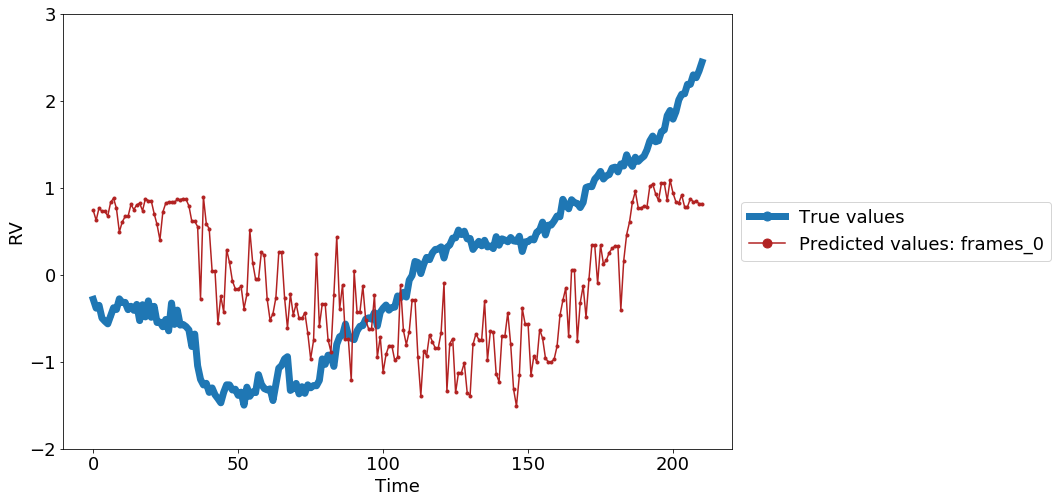

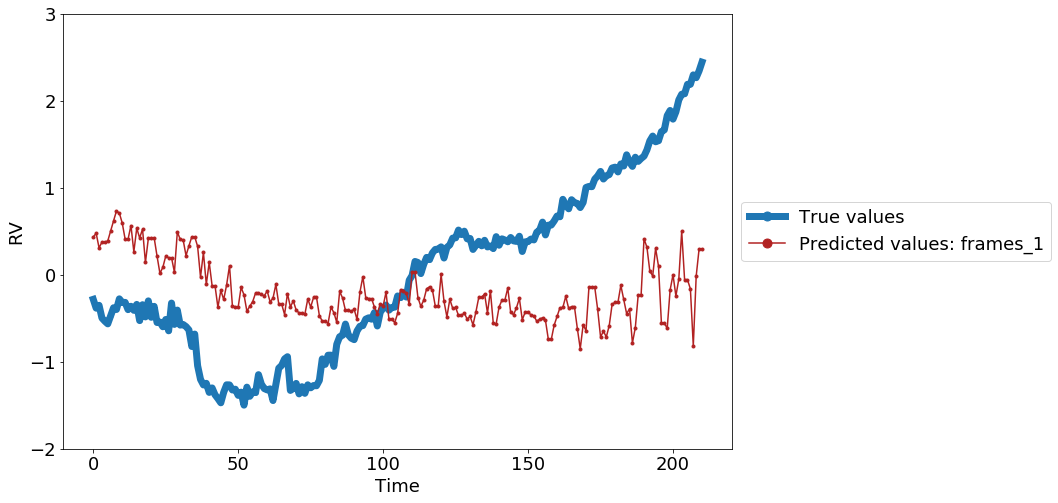

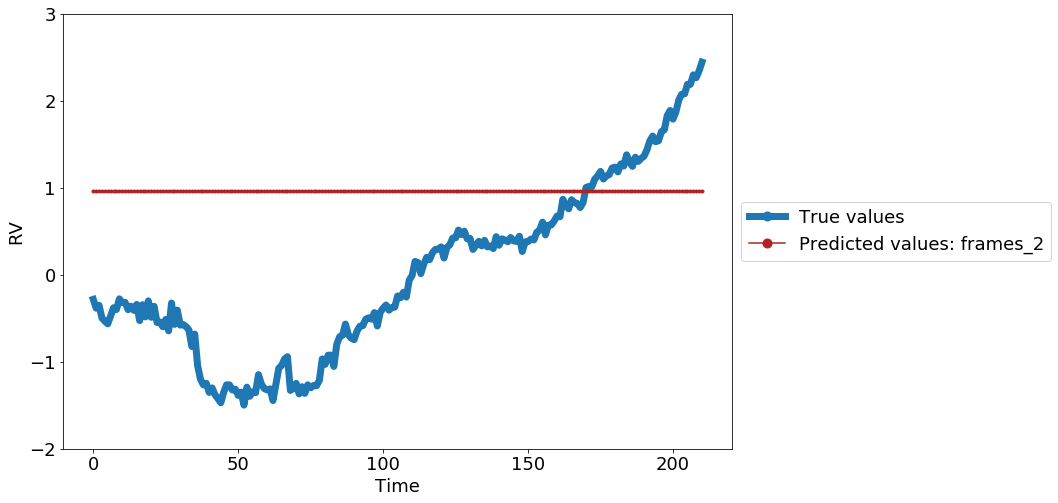

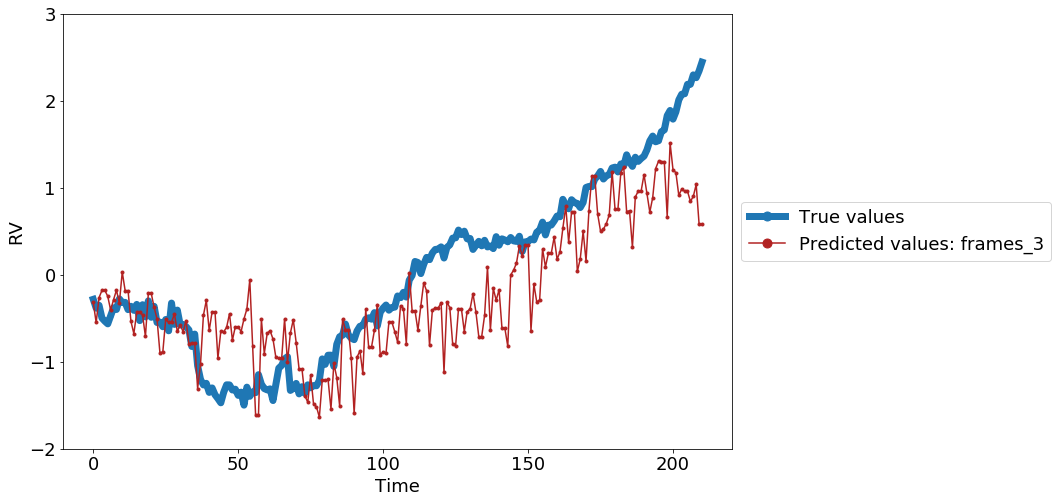

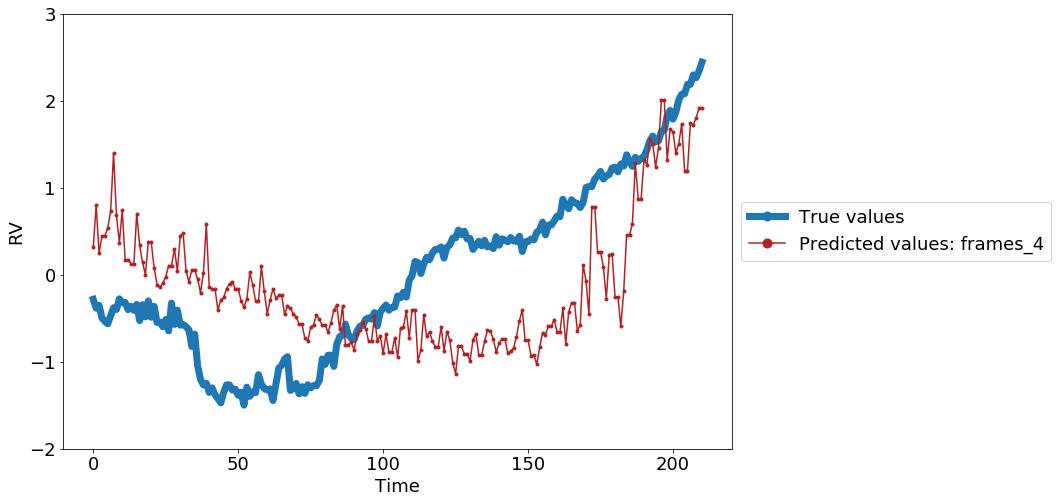

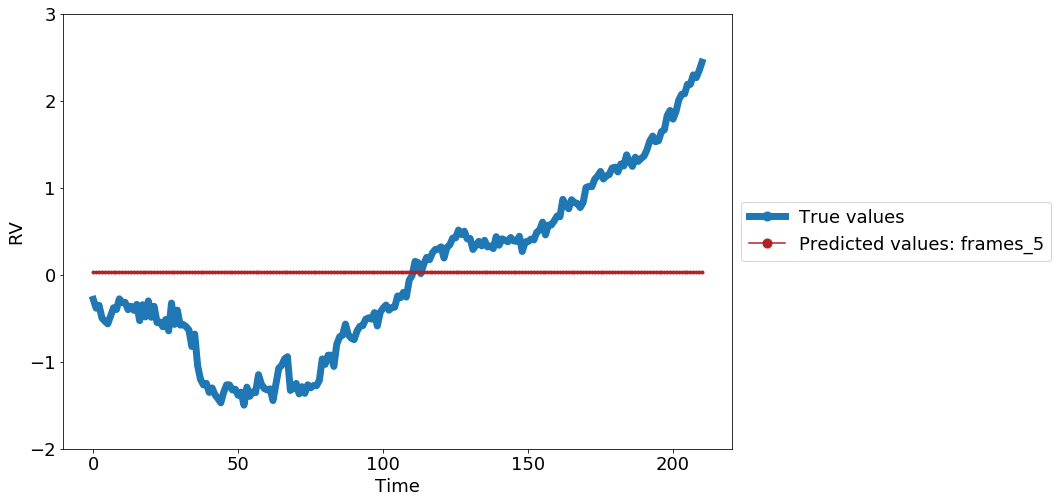

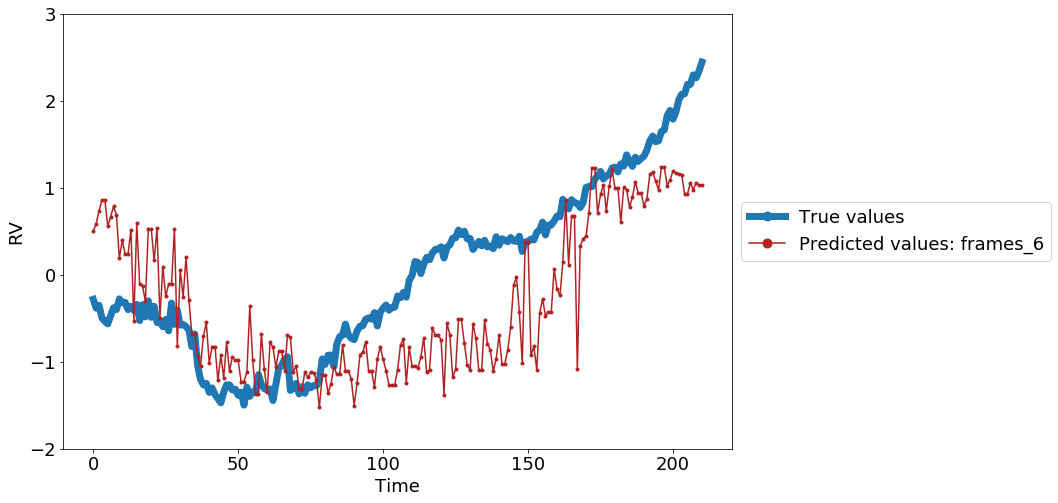

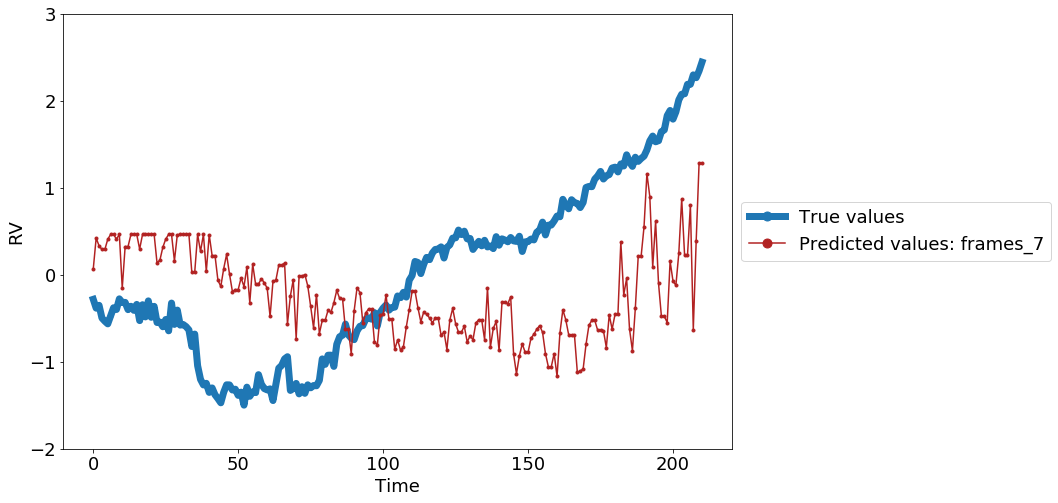

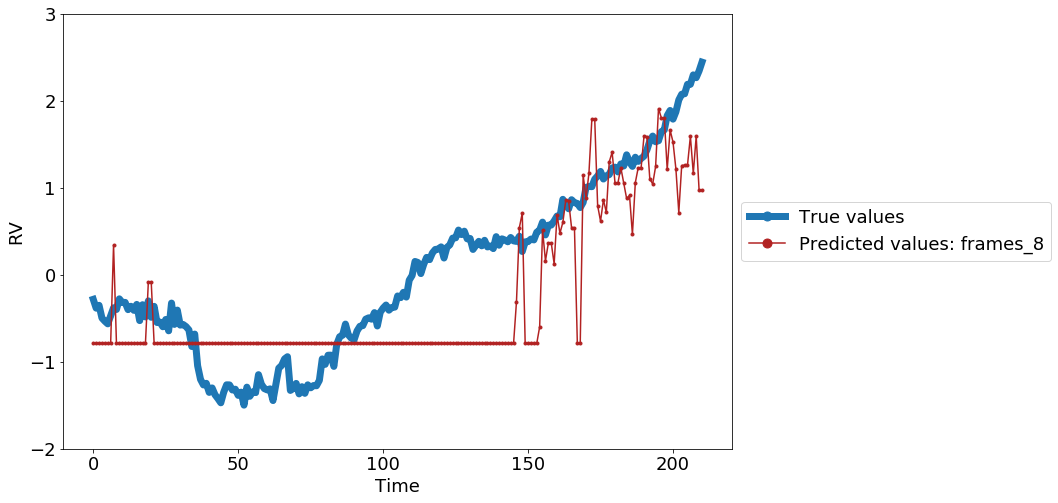

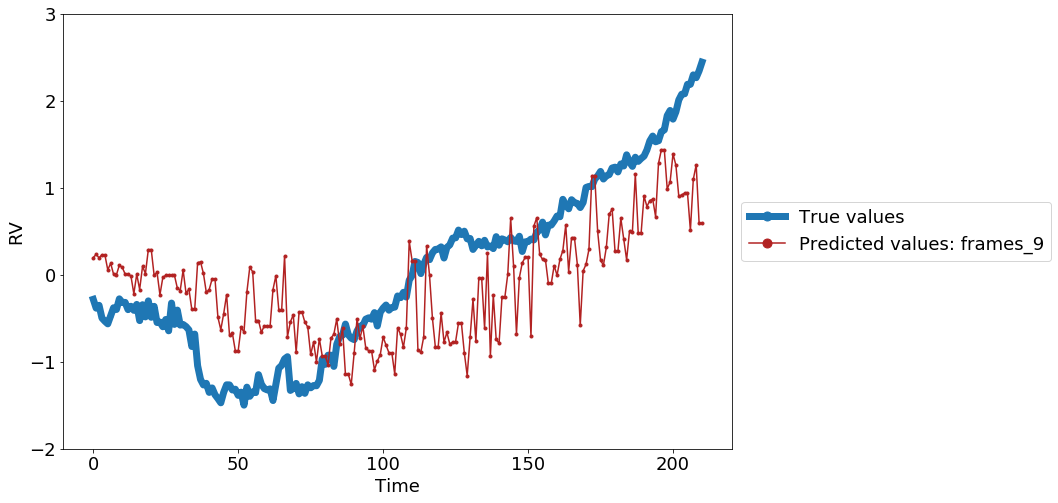

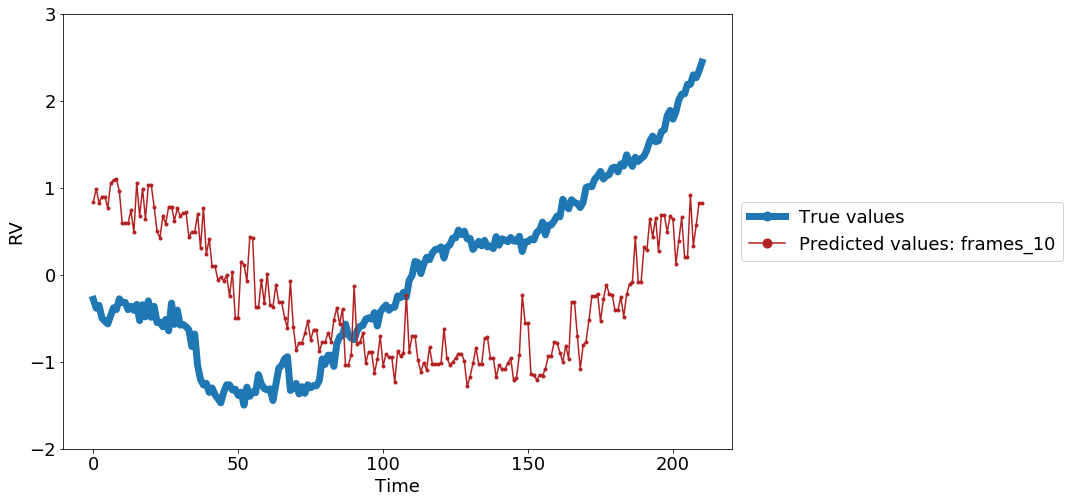

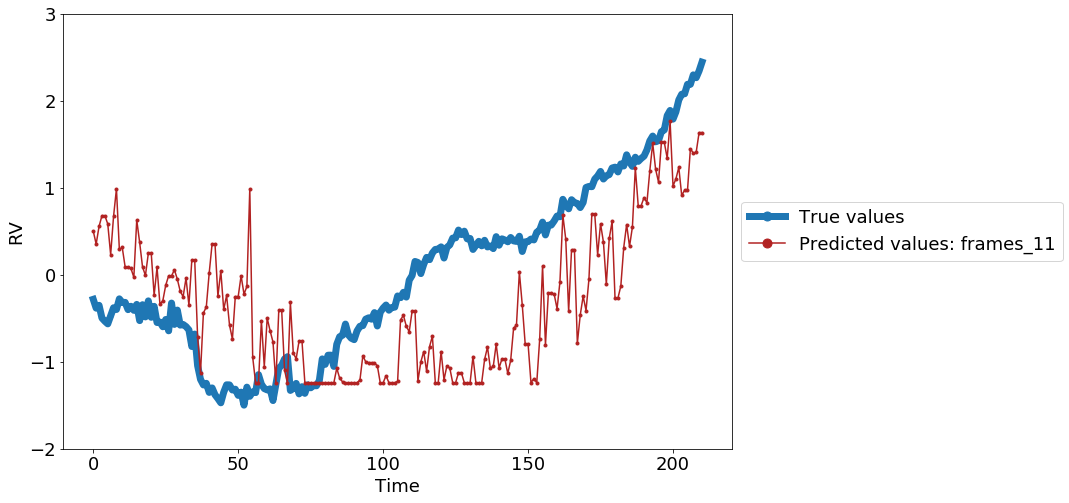

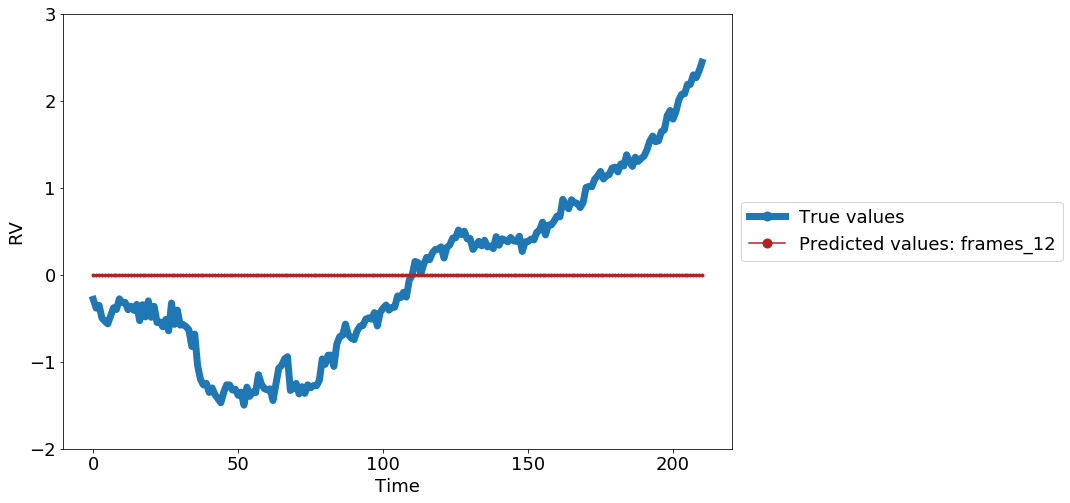

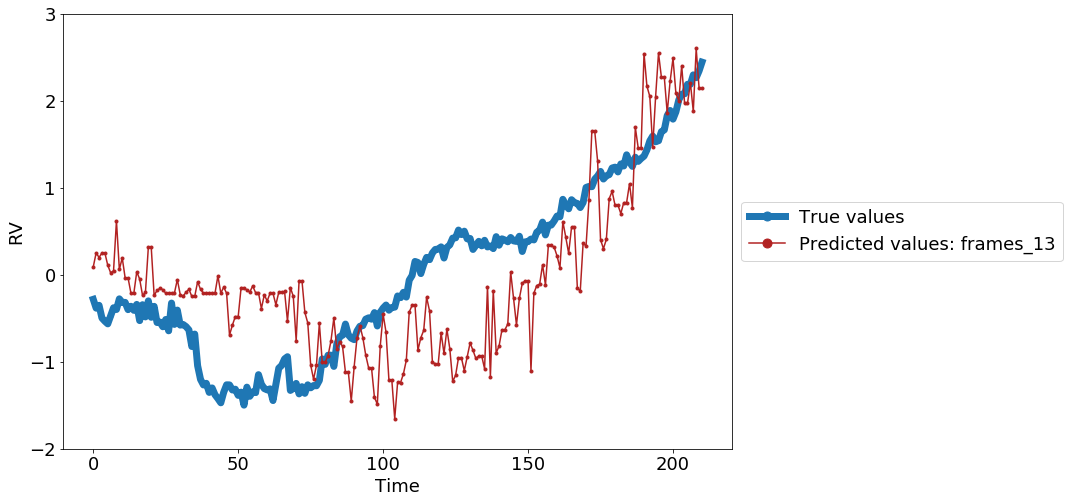

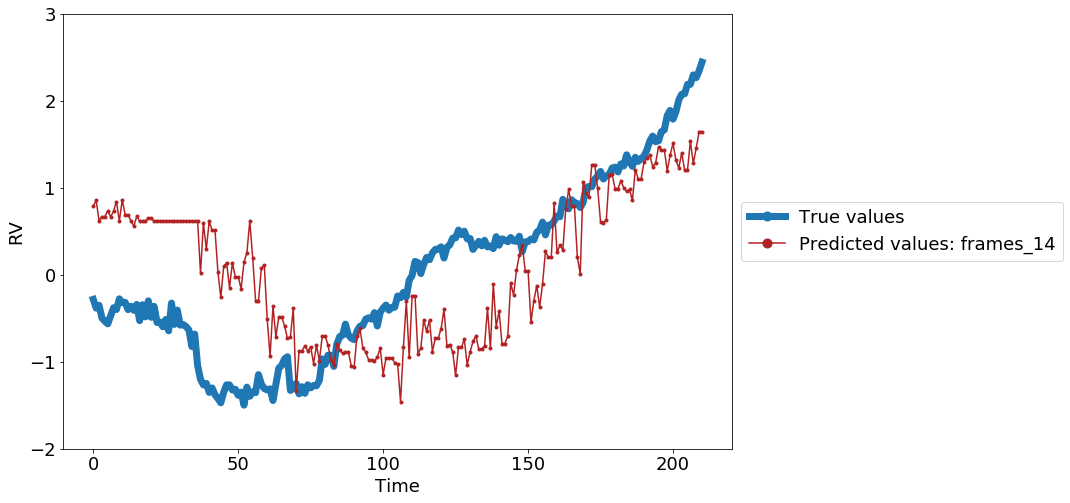

In [34]:
seed = 42

time =  df5_s[:,0]

X_test = df5_s[:,3:]
y_test = df5_s[:,1]

# X_test = np.array([df1_s[:,8], df1_s[:,14]]).T
# y_test = df1_s[:,1]


# Create a model with no hyperparameters


class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=5),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 100

#markers = ['v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', '+', 'X']



for i in tqdm(range(len(output))):
    
    plt.figure(figsize=(12,8))

    # Initialize
    clf_NN = MLPRegressor(learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)
    RandomSearch = RandomizedSearchCV(clf_NN, 
                                      param_distributions=parameters_RandomSearch, 
                                      n_iter=n_iter_search, 
                                      cv=5,  
                                      return_train_score=True,
                                      random_state=0,
                                      verbose = False, 
                                      n_jobs = -1,
                                      scoring = 'neg_root_mean_squared_error')


    frames = output[i]
    
#     X_rear, X_centre = np.array(np.concatenate((frames)))[:,8], np.array(np.concatenate((frames)))[:,14]
#     X = np.array([X_rear, X_centre]).T
    X = np.array(np.concatenate(frames))[:,3:]
    y = np.array(np.concatenate(frames))[:,1]
    
    # fit the random search instance
    RandomSearch.fit(X, y);

    print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

    ypred = RandomSearch.predict(X_test)


#     if i == 0:
#         plt.plot(y_test, '.-', color='C0', linewidth = 7, label = 'True values')
    plt.plot(y_test, '.-', color='C0', linewidth = 7, label = 'True values')
    plt.plot(ypred, '.-', color='firebrick', label = f'Predicted values: frames_{i}')
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.ylim(-2,3)
    plt.legend(markerscale=3, loc='center left', bbox_to_anchor=(1, 0.5));

    plt.show

# XGBoost

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

[18:50:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
  7%|█████▌                                                                             | 1/15 [00:00<00:10,  1.33it/s]


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 13%|███████████                                                                        | 2/15 [00:01<00:09,  1.42it/s]

[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bi

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 20%|████████████████▌                                                                  | 3/15 [00:01<00:07,  1.52it/s]


[18:50:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 27%|██████████████████████▏                                                            | 4/15 [00:02<00:07,  1.50it/s]


[18:50:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 33%|███████████████████████████▋                                                       | 5/15 [00:03<00:07,  1.39it/s]

 {'eta': 0.020584494295802447, 'max_depth': 2, 'num_round': 8} , Best scores: -0.83231
[18:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not b


[18:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 40%|█████████████████████████████████▏                                                 | 6/15 [00:04<00:06,  1.32it/s]


[18:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 47%|██████████████████████████████████████▋                                            | 7/15 [00:05<00:06,  1.23it/s]


[18:50:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 53%|████████████████████████████████████████████▎                                      | 8/15 [00:05<00:05,  1.29it/s]


[18:50:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Random Search: 	Best parameters:  {'eta': 0.020584494295802447, 'max_depth': 2, 'num_round': 8} , Best scores: -0.86389
[18:50:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Par


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:06<00:04,  1.25it/s]


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:07<00:03,  1.26it/s]


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:08<00:03,  1.19it/s]


[18:50:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:09<00:02,  1.09it/s]


[18:50:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:10<00:01,  1.05it/s]

[18:50:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Random Search: 	Best parameters:  {'eta': 0.020584494295802447, 'max_depth': 2, 'num_round': 8} , Best scores: 0.13440
[18:50:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Param


[18:50:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:11<00:00,  1.07it/s]


[18:50:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b


[18:50:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

C:\Users\Marcus96\anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.18it/s]

 {'eta': 0.020584494295802447, 'max_depth': 2, 'num_round': 8} , Best scores: -0.26172


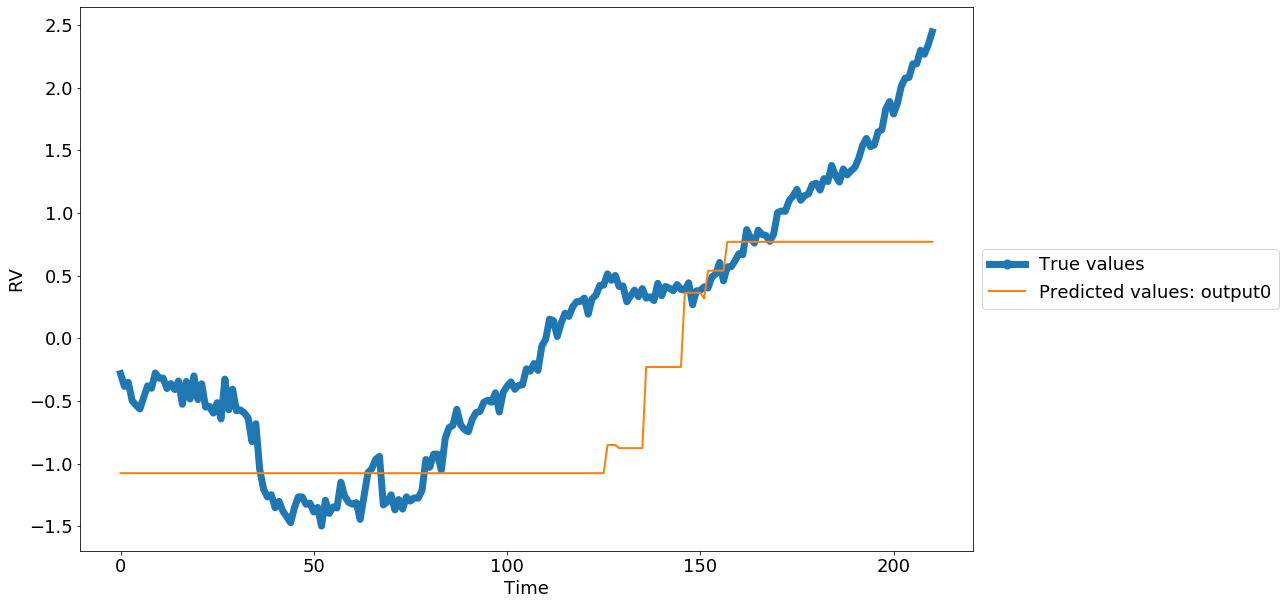

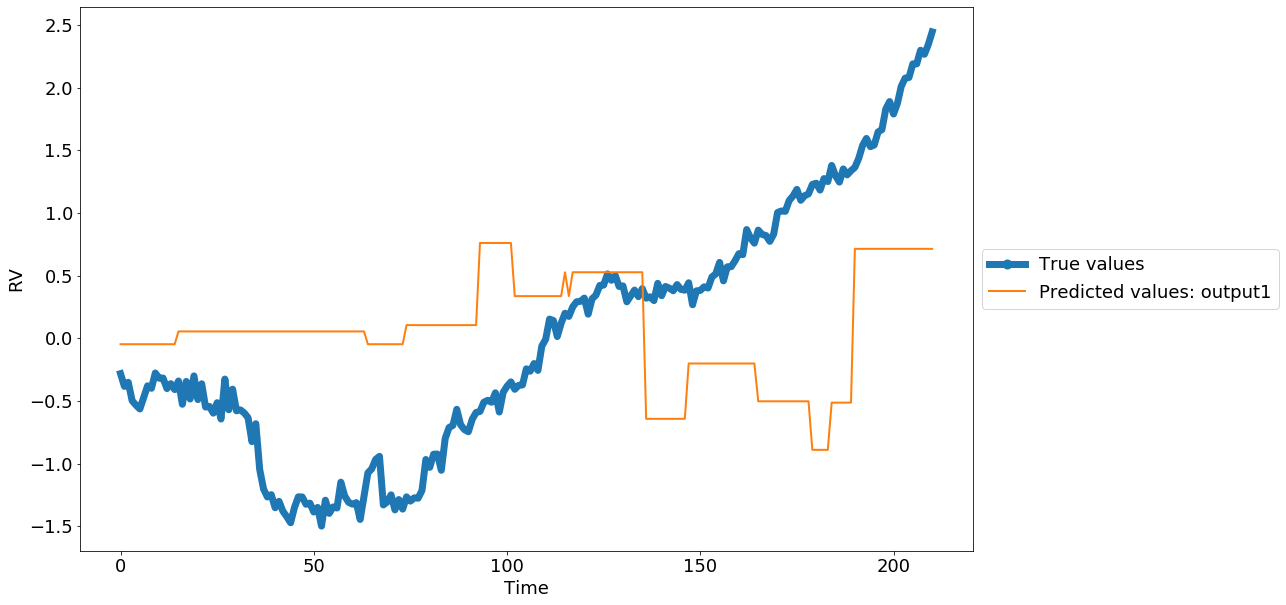

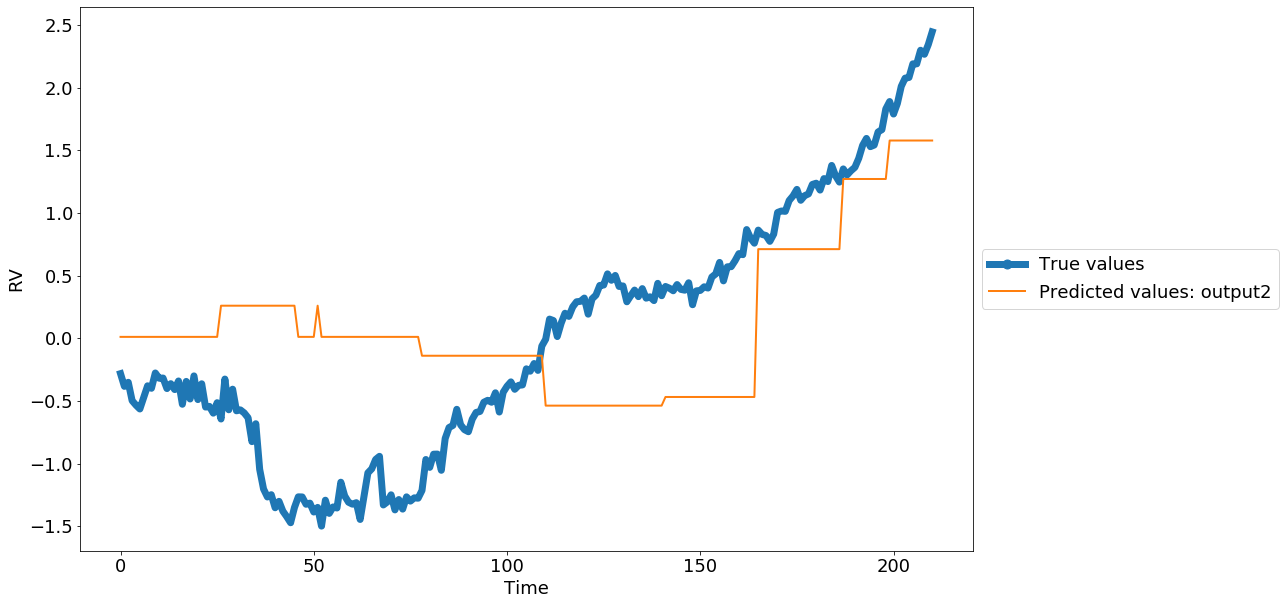

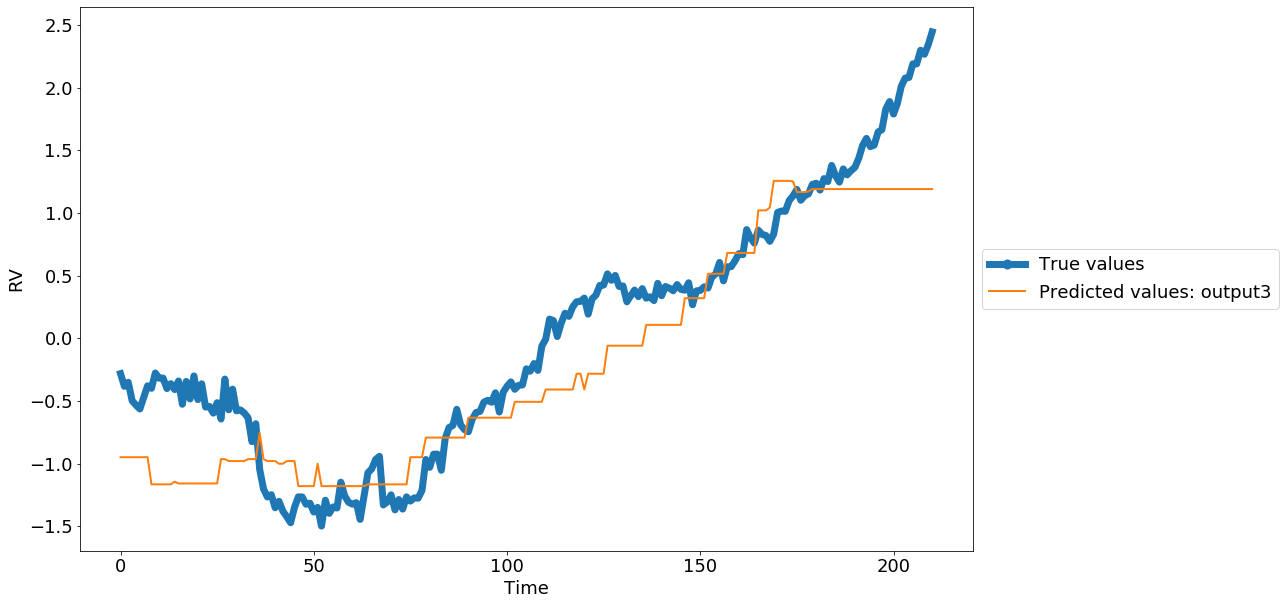

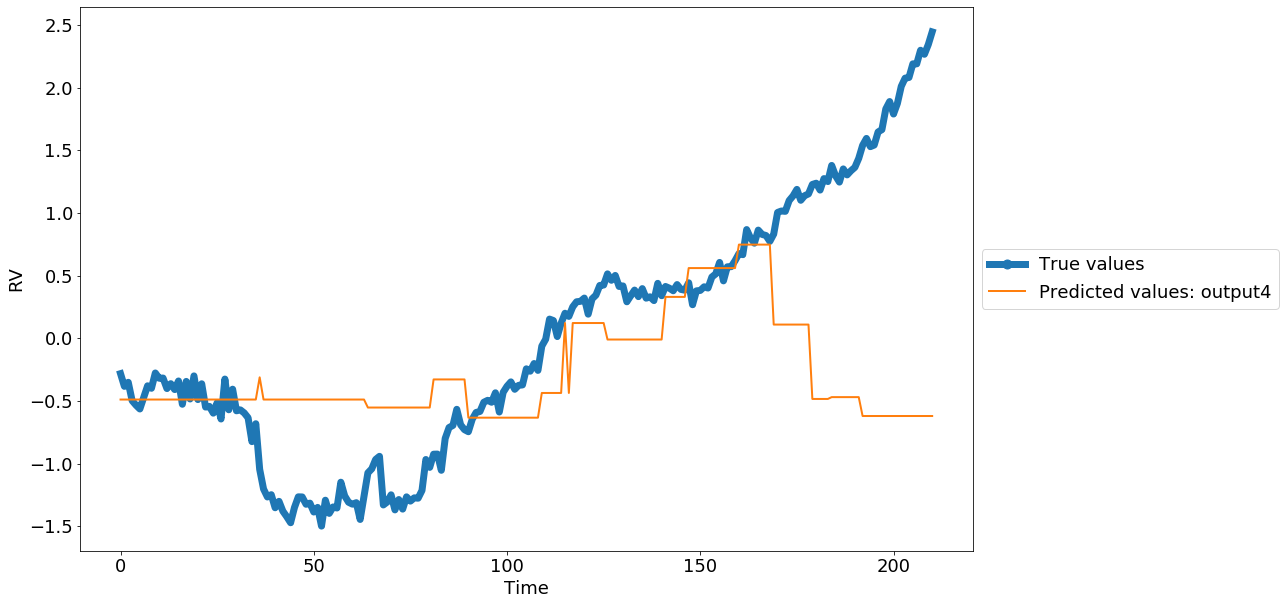

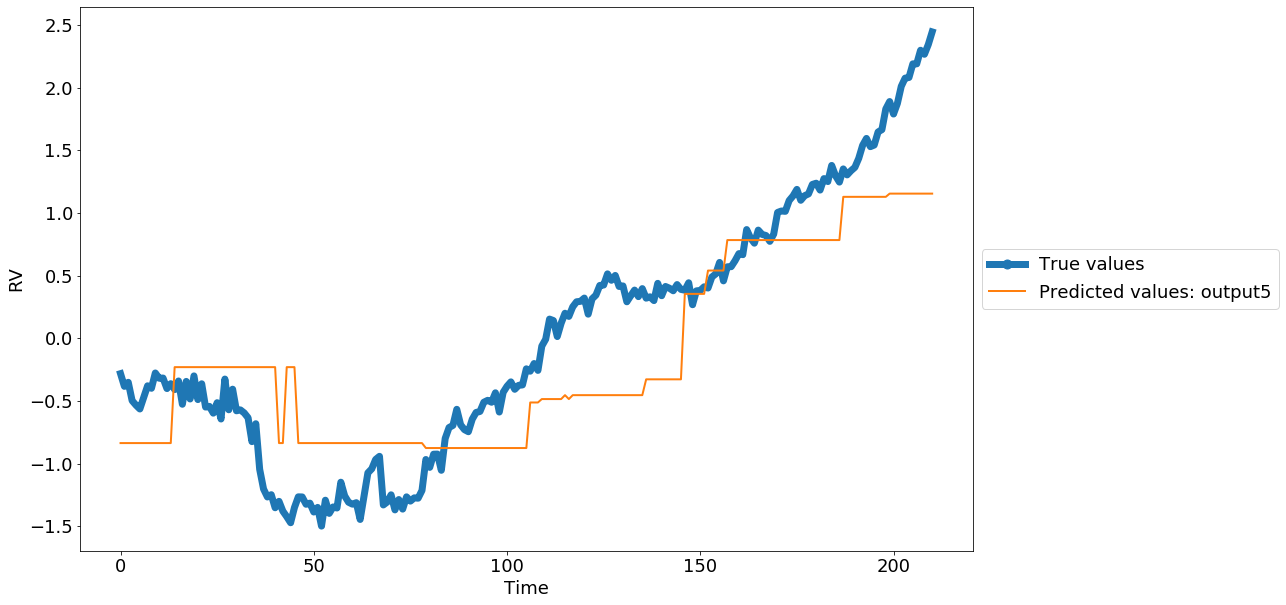

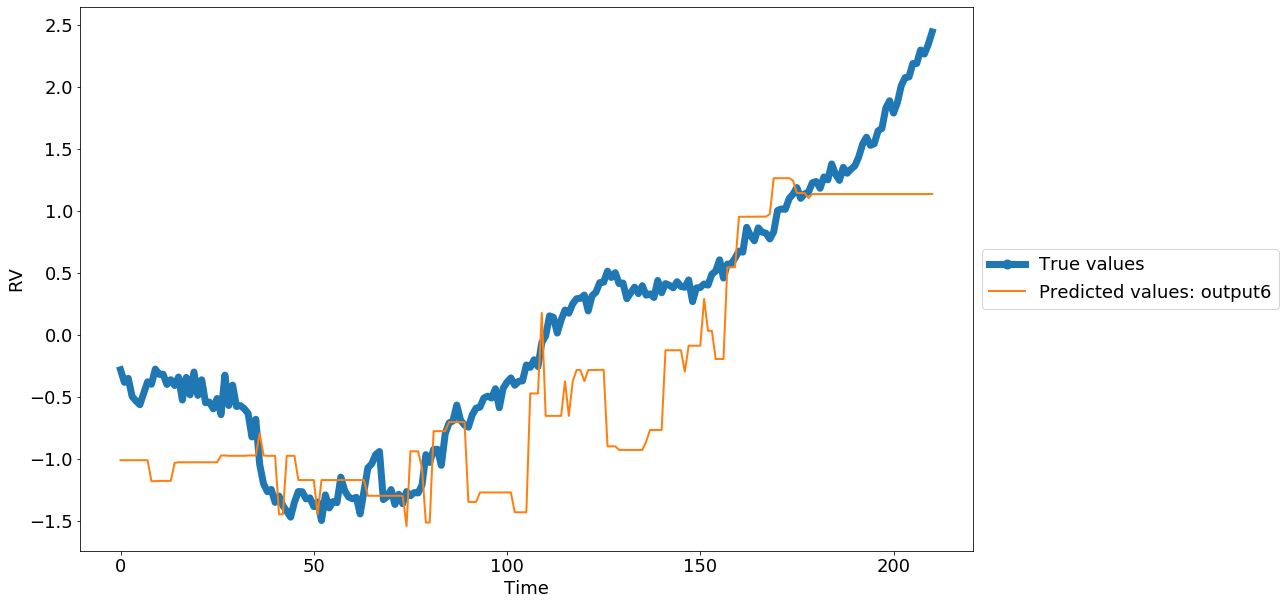

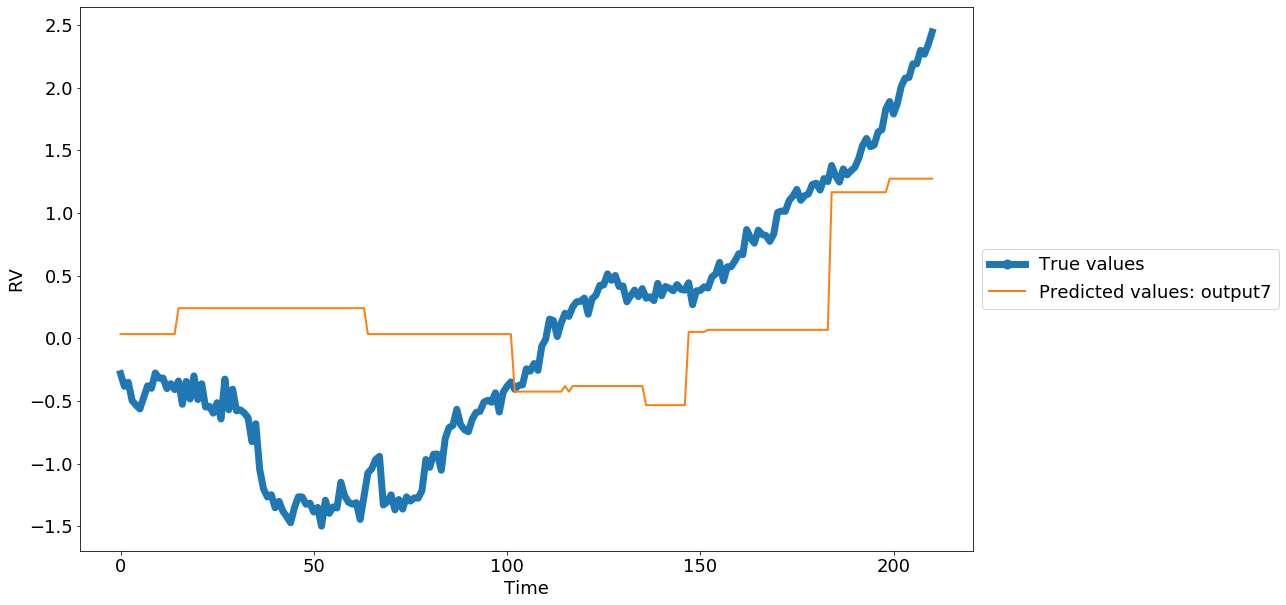

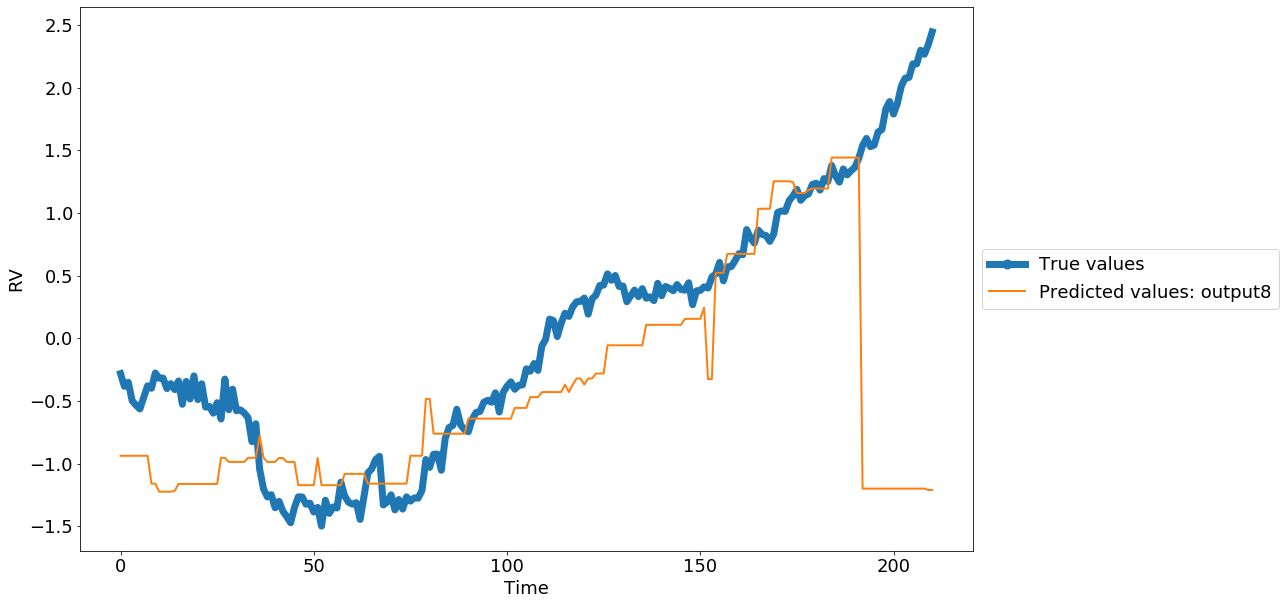

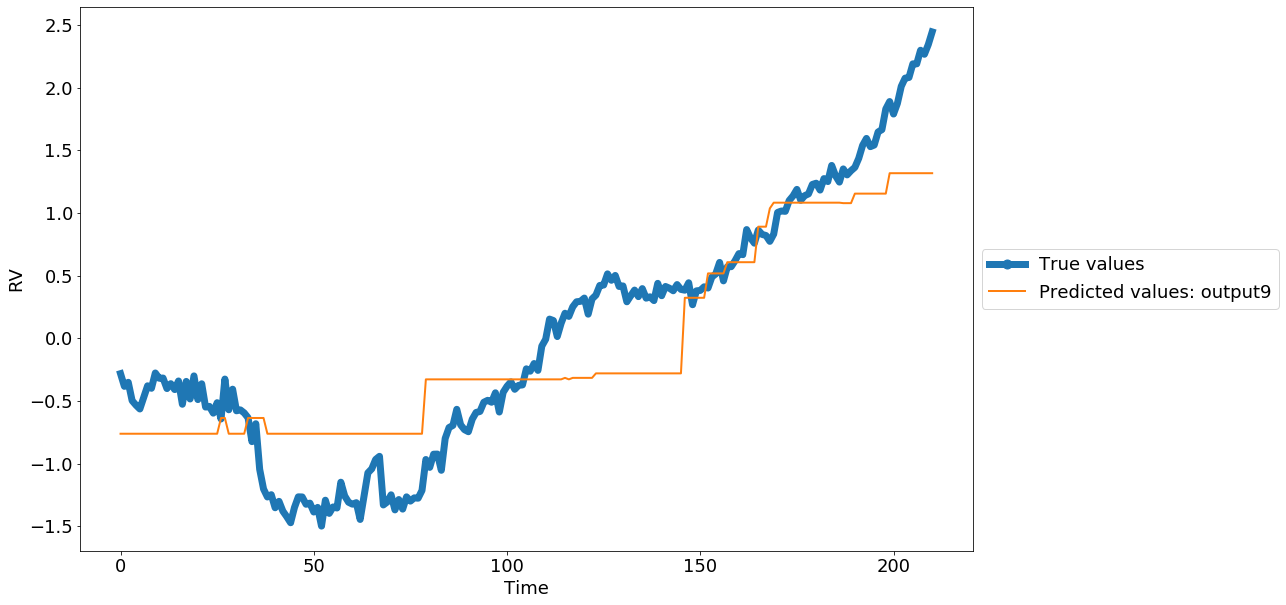

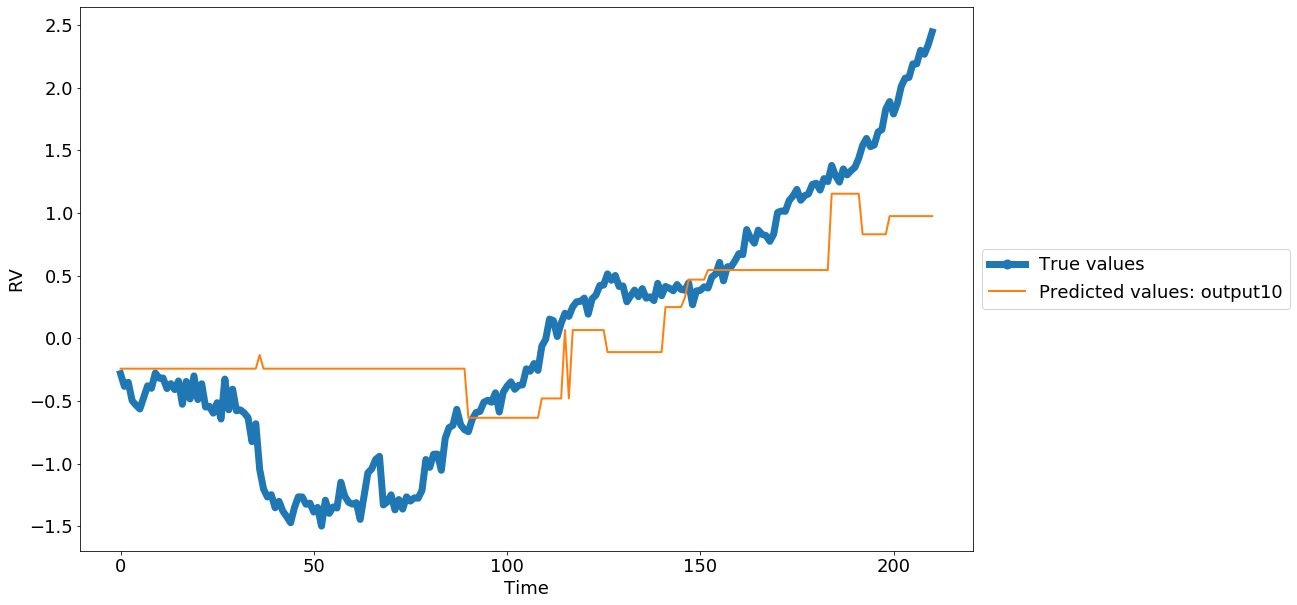

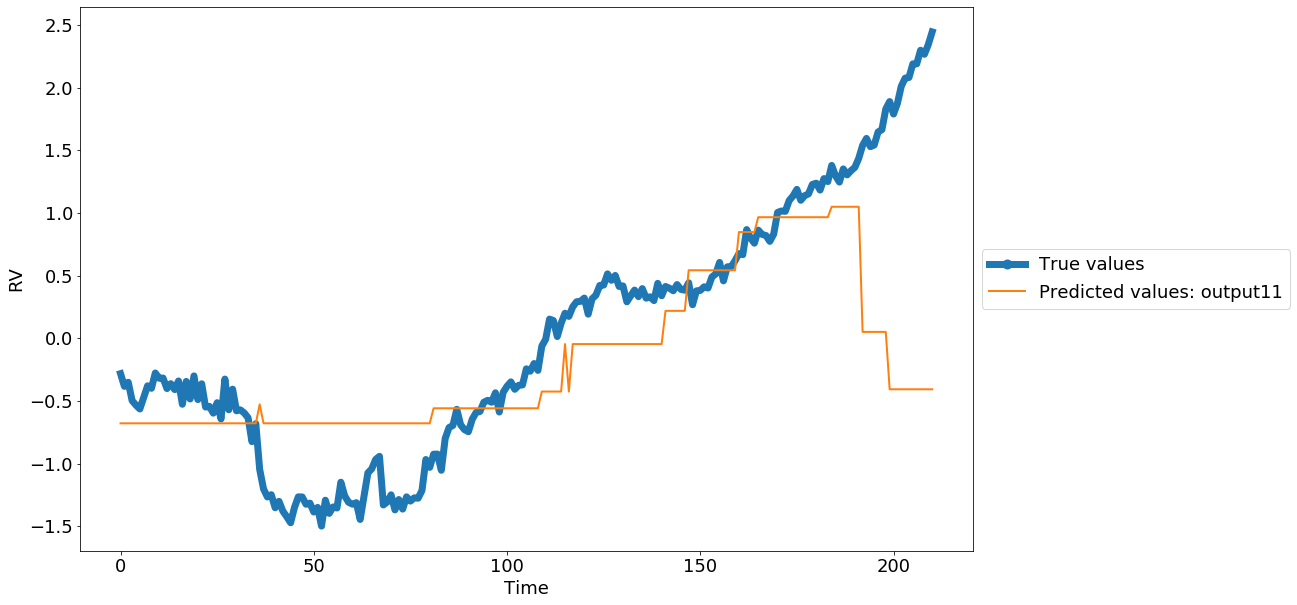

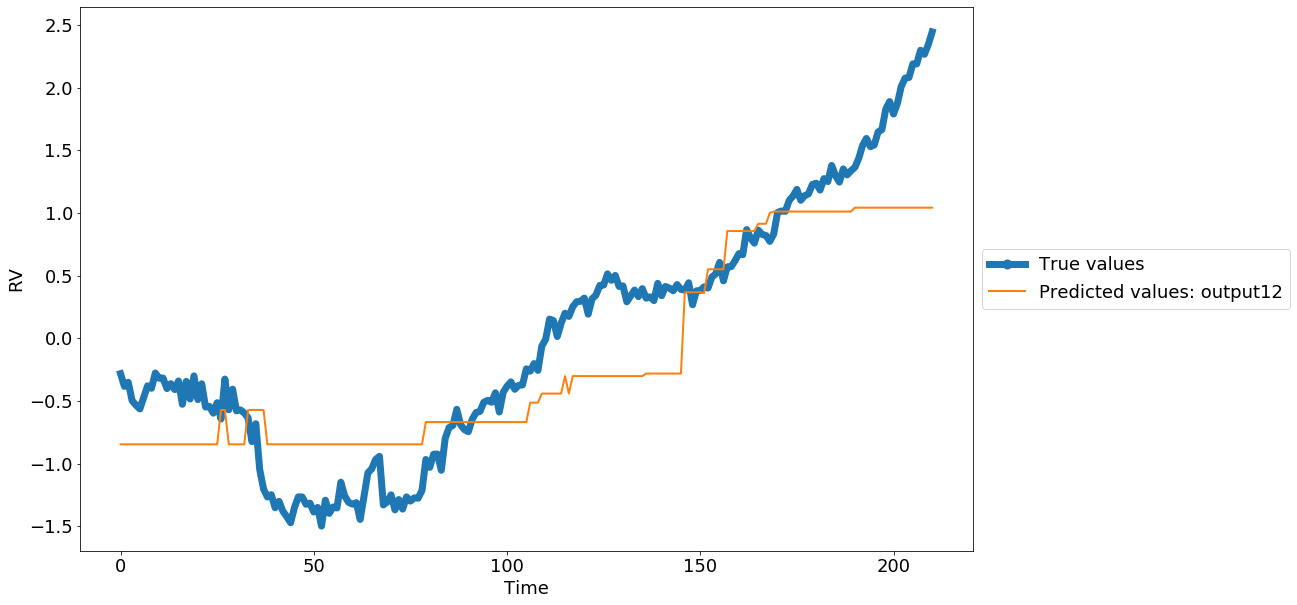

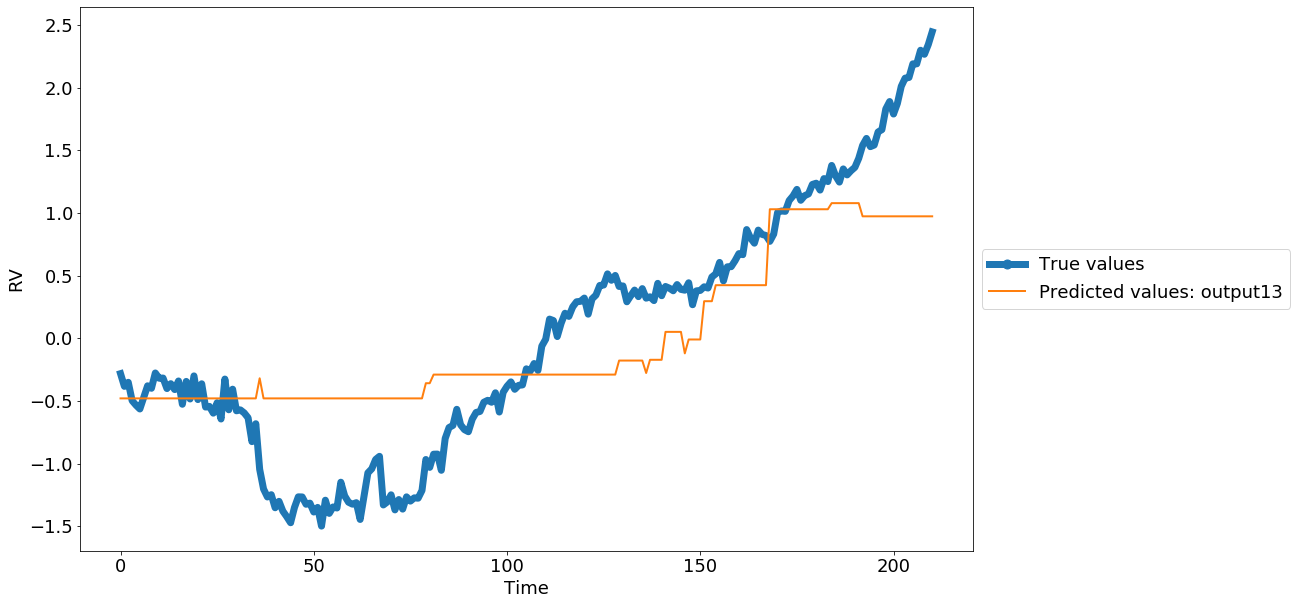

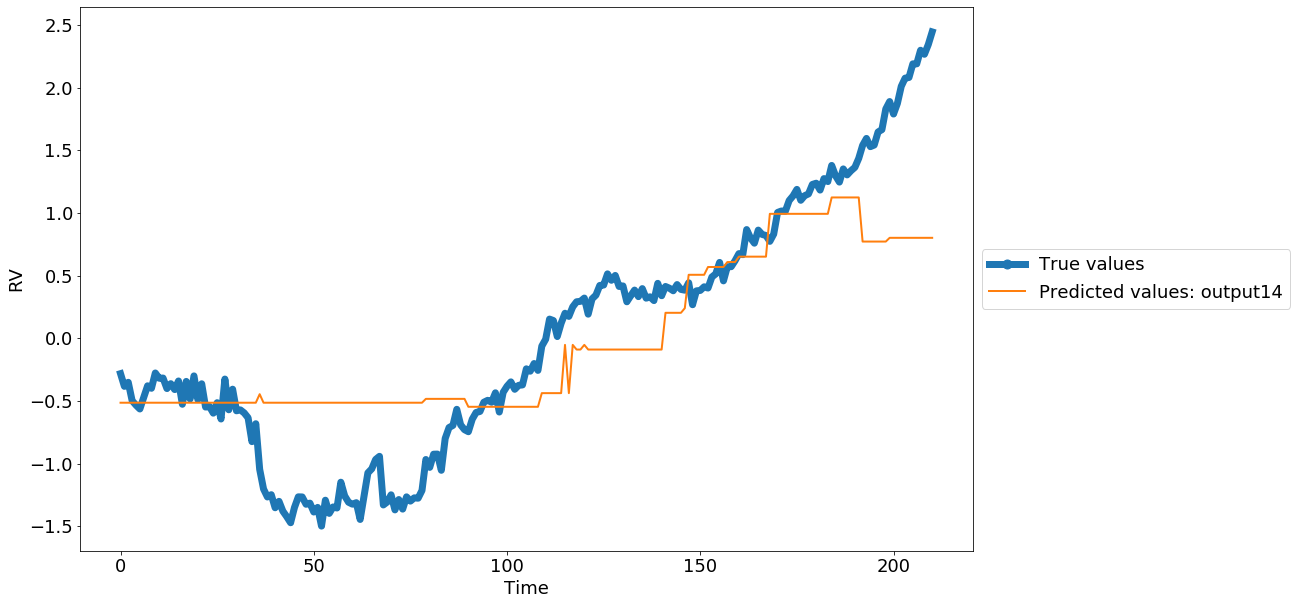

In [35]:
# X_test = df5_s[:,3:]
# y_test = df5_s[:,1]

X_test = np.array([df5_s[:,8], df5_s[:,14]]).T
y_test = df5_s[:,1]




for i in tqdm(range(len(output))):
    
    plt.figure(figsize=(16,10))
    
    frames = output[i]
    #X = np.array(np.concatenate(frames))[:,3:]
    y = np.array(np.concatenate(frames))[:,1]
    X_rear, X_centre = np.array(np.concatenate((frames)))[:,8], np.array(np.concatenate((frames)))[:,14]
    X = np.array([X_rear, X_centre]).T
    
    
    seed = 42

    parameters_RandomSearch = {'eta': st.uniform(), 
                               'num_round': st.randint(1,11),
                               'max_depth': st.randint(1,10)}

    clf_xgb = xgb.XGBRegressor(random_state = seed)

    n_iter_search = 10

    exp_var = make_scorer(explained_variance_score)
    r2 = make_scorer(r2_score)



    RandomSearch = RandomizedSearchCV(clf_xgb, 
                                      param_distributions=parameters_RandomSearch, 
                                      n_iter=n_iter_search, 
                                      cv=5, 
                                      return_train_score=True,
                                      random_state=seed,
                                      verbose = False,
                                      scoring = exp_var)
    
    RandomSearch.fit(X, y);
    print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.5f}")
    ypred = RandomSearch.predict(X_test)
    
    #if i == 0:
#         plt.plot(y_test, '.-', color='C0', linewidth = 7, label = 'True values')
    plt.plot(y_test, '.-', color='C0', linewidth = 7, label = 'True values')
    plt.plot(ypred, '-', color='C1', linewidth = 2, label = f'Predicted values: output{i}')
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.legend(markerscale=3, loc='center left', bbox_to_anchor=(1, 0.5));
    
    plt.show

# Pride plot with NN

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [30:34<00:00, 366.84s/it]


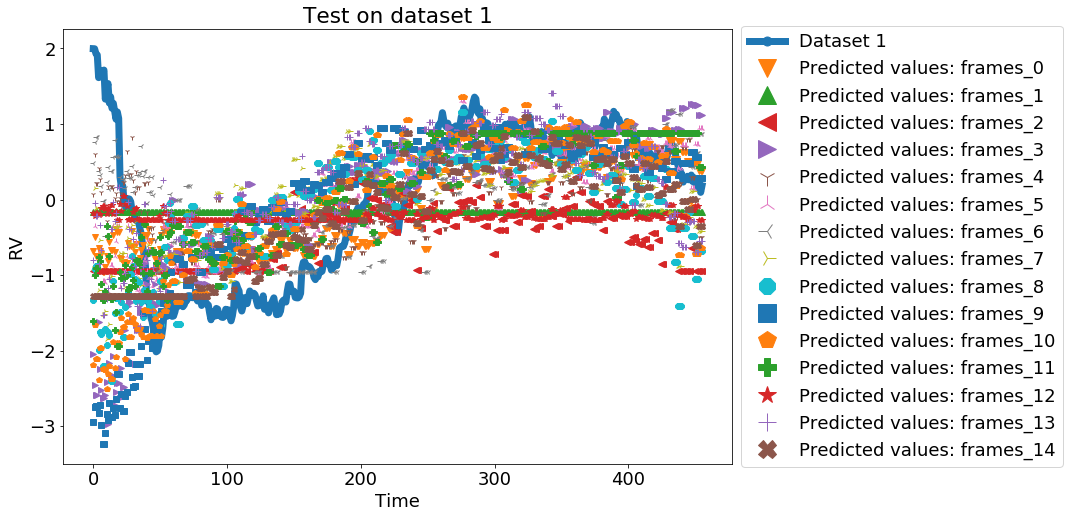

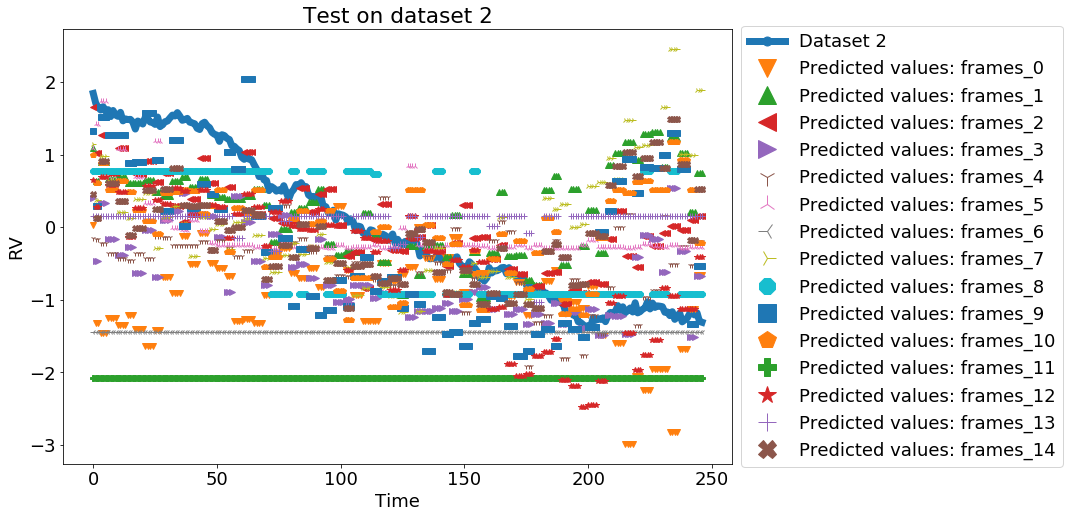

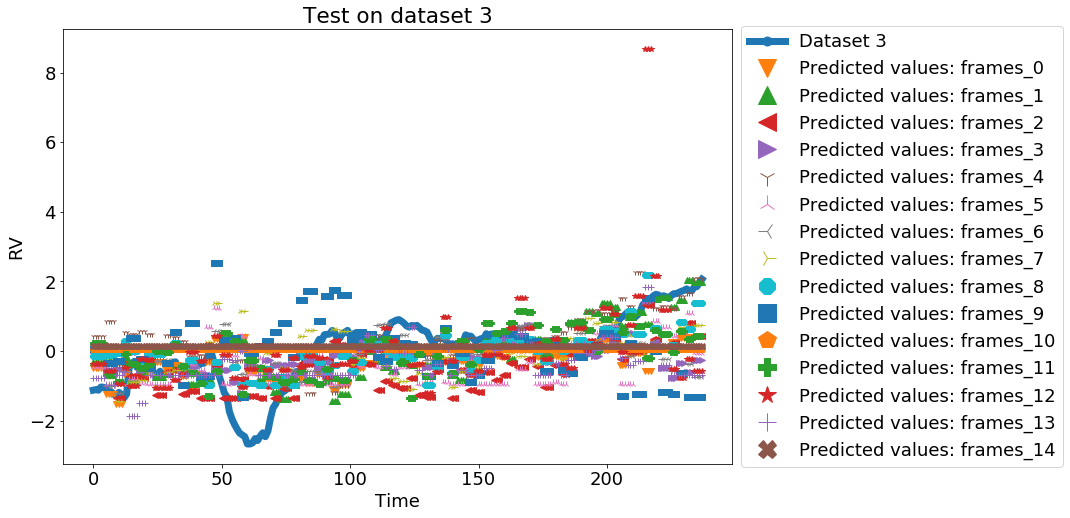

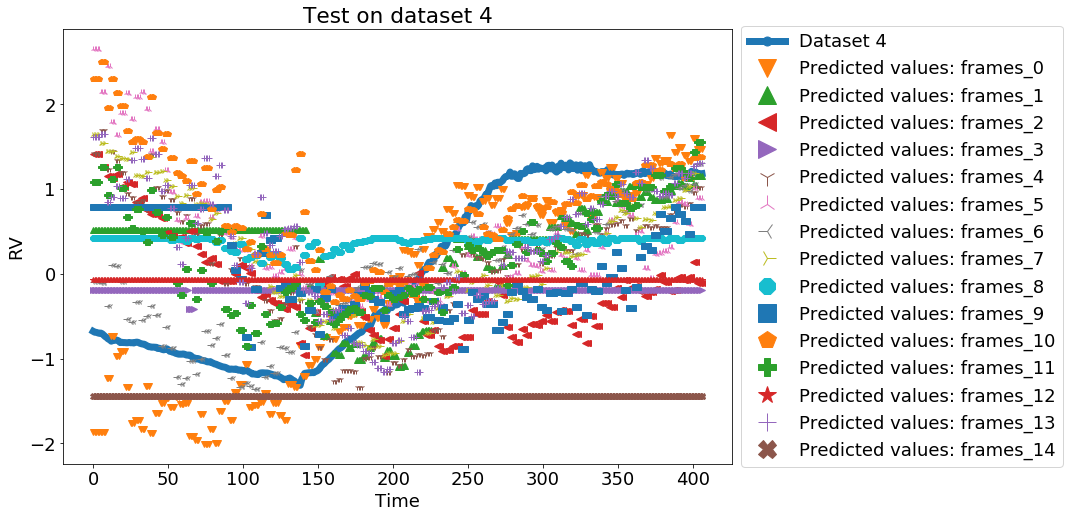

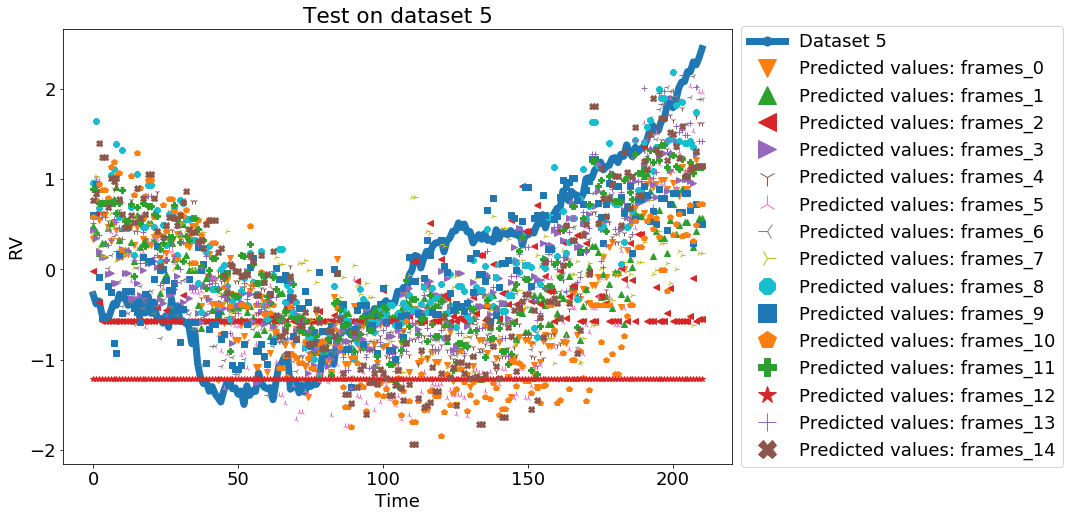

In [36]:
seed = 42

frame_tot = np.array(([df2_s, df3_s, df4_s, df5_s], [df3_s, df4_s, df5_s, df1_s],
                    [df4_s, df5_s, df1_s, df2_s], [df5_s, df1_s, df2_s, df3_s], [df1_s, df2_s, df3_s, df4_s]))

df_test = np.array([df1_s, df2_s, df3_s, df4_s, df5_s])





# Create a model with no hyperparameters


class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=5),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 100

markers = ['v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', '+', 'X']



for j in tqdm(range(len(df_test))):
    
    
    plt.figure(figsize=(12,8))

    X_test = df_test[j][:,3:]
    y_test = df_test[j][:,1]
    
    # X_test = np.array([df_test[j][:,8], df_test[j][:,14]]).T
    # y_test = df_test[j][:,1]
    
    input = frame_tot[j]

    output = sum([list(map(list, combinations(input, i))) for i in range(len(input) + 1)], [])
    output = output[1:]


    for i in range(len(output)):


        # Initialize
        clf_NN = MLPRegressor(learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)
        RandomSearch = RandomizedSearchCV(clf_NN, 
                                          param_distributions=parameters_RandomSearch, 
                                          n_iter=n_iter_search, 
                                          cv=5,  
                                          return_train_score=True,
                                          random_state=0,
                                          verbose = False, 
                                          n_jobs = -1,
                                          scoring = 'neg_root_mean_squared_error')


        frames = output[i]

    #     X_rear, X_centre = np.array(np.concatenate((frames)))[:,8], np.array(np.concatenate((frames)))[:,14]
    #     X = np.array([X_rear, X_centre]).T
        X = np.array(np.concatenate(frames))[:,3:]
        y = np.array(np.concatenate(frames))[:,1]

        # fit the random search instance
        RandomSearch.fit(X, y);

        #print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

        ypred = RandomSearch.predict(X_test)


        if i == 0:
            plt.plot(y_test, '.-', color='C0', linewidth = 7, label = f'Dataset {j+1}')
        #plt.plot(y_test, '.-', color='C0', linewidth = 7, label = 'True values')
        plt.plot(ypred, '.', marker = markers[i], color=f'C{i+1}', label = f'Predicted values: frames_{i}')
        plt.xlabel('Time')
        plt.ylabel('RV')
        #plt.ylim(-2,3)
        plt.legend(markerscale=3, loc='center left', bbox_to_anchor=(1, 0.5));
        
    plt.title(f'Test on dataset {j+1}')

    plt.show